# High-throughput Tweet-sequencing (HTT) analysis  
## YoSon @yosons

## Challenge: Can we see the impact of a talk based on HTT?  
### Caveats: False positives, Retweets, Discrete time points, Data pulling limitations on API  

first, read in some newest tweets

In [ ]:
%%bash
# API seems to have an upper bound at ~3000 tweets
timepoint=`date +'%Y%m%d%H%M%S'
t search all '#ASHG16' -n 4000 --csv > ashg16_5000_${timepoint}`.csv

let's see what I have

In [1]:
#!/usr/bin/env python3.4

import matplotlib.pyplot as plt
import pandas as pd
import sys, os

# example file
tfile = 'ashg16_5000_20161022095400.csv'
# tfile = sys.argv[1]

df = pd.read_csv(tfile, sep=',', header=0)

df.head()

,ID,Posted at,Screen name,Text
0,789825935046389762,2016-10-22 13:49:11 +0000,actually_alan,"RT @scilahn: Have iPhone, will sequence with @..."
1,789824965524742145,2016-10-22 13:45:20 +0000,lighketsho,обслуживание гбо #ASHG16 https://t.co/VEauteeXUE
2,789823658218889216,2016-10-22 13:40:08 +0000,seankenneths,RT @ben_lengerich: @manoliskellis crushing the...
3,789823313384239104,2016-10-22 13:38:46 +0000,yokonaga405,RT @EricTopol: Crowdsourced personal genomes: ...
4,789823305796640772,2016-10-22 13:38:44 +0000,spwells,Ciao #ASHG16 - it's been an awesome week. See ...


step: remove retweets    
false negative: People whose initials are RT, genes and other keywords with suffix RT, ...  

In [2]:
df1 = df[~df['Text'].str.startswith('RT @')]
df.info()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
ID             5000 non-null int64
Posted at      5000 non-null object
Screen name    5000 non-null object
Text           5000 non-null object
dtypes: int64(1), object(3)
memory usage: 156.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3191 entries, 1 to 4998
Data columns (total 4 columns):
ID             3191 non-null int64
Posted at      3191 non-null object
Screen name    3191 non-null object
Text           3191 non-null object
dtypes: int64(1), object(3)
memory usage: 124.6+ KB


positive control: There are talks I know the approximate contents of and also happened to have been well-tweeted by some heavy hitters. Let's see examples.  
    
step: select tweets that contain the initial or partial name  
false negative: misspelled name, initials with spaces, ...  
false positive: keywords that contain the same letters as initial (less likley for the name)  
    
feature extraction: tweet-sequence read length by character lenght of the tweet     

In [3]:
km = df1[df1['Text'].str.contains('KM|usunuru')]
km = km[km['Posted at'].str.contains('2016-10-21')]
km['date'], km['time'], km['nano'] = zip(*km["Posted at"].str.split(' ').tolist())
km['time'] = km['time'].str.replace(':','')
km['time'] = km['time'].astype(int)
km = km.ix[(km['time']>170000) & (km['time']<190000)]
km.reset_index(drop=True, inplace=True)
km.reset_index(inplace=True)
km.to_csv('htt_example_km.txt', sep='\t', index=False)
km.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 8 columns):
index          87 non-null int64
ID             87 non-null int64
Posted at      87 non-null object
Screen name    87 non-null object
Text           87 non-null object
date           87 non-null object
time           87 non-null int64
nano           87 non-null object
dtypes: int64(3), object(5)
memory usage: 5.5+ KB


I didn't install new rpy2 (I have heard that it's fianlly ported to py3 though). So R is run separately.

In [ ]:
%%R 

library(ggplot2)

df <- read.csv('htt_example_km.txt', sep='\t', header=TRUE)
df['reads'] = data.frame(Text=df$Text,nchr=apply(df,2,nchar)[,'Text'])$nchr

png('htt_example_km.png',width=12,height=2,units='in',res=300)

ggplot(df, aes(x=time, y=Screen.name, colour=Screen.name)) + 
  geom_tile(aes(fill=Screen.name, width=reads), colour='black') +
  scale_color_brewer(palette='Set2') + theme_bw() +
  labs(x='time', y='username', title='talk coverage', fill='username')
  
dev.off()


display image for Kiran's talk

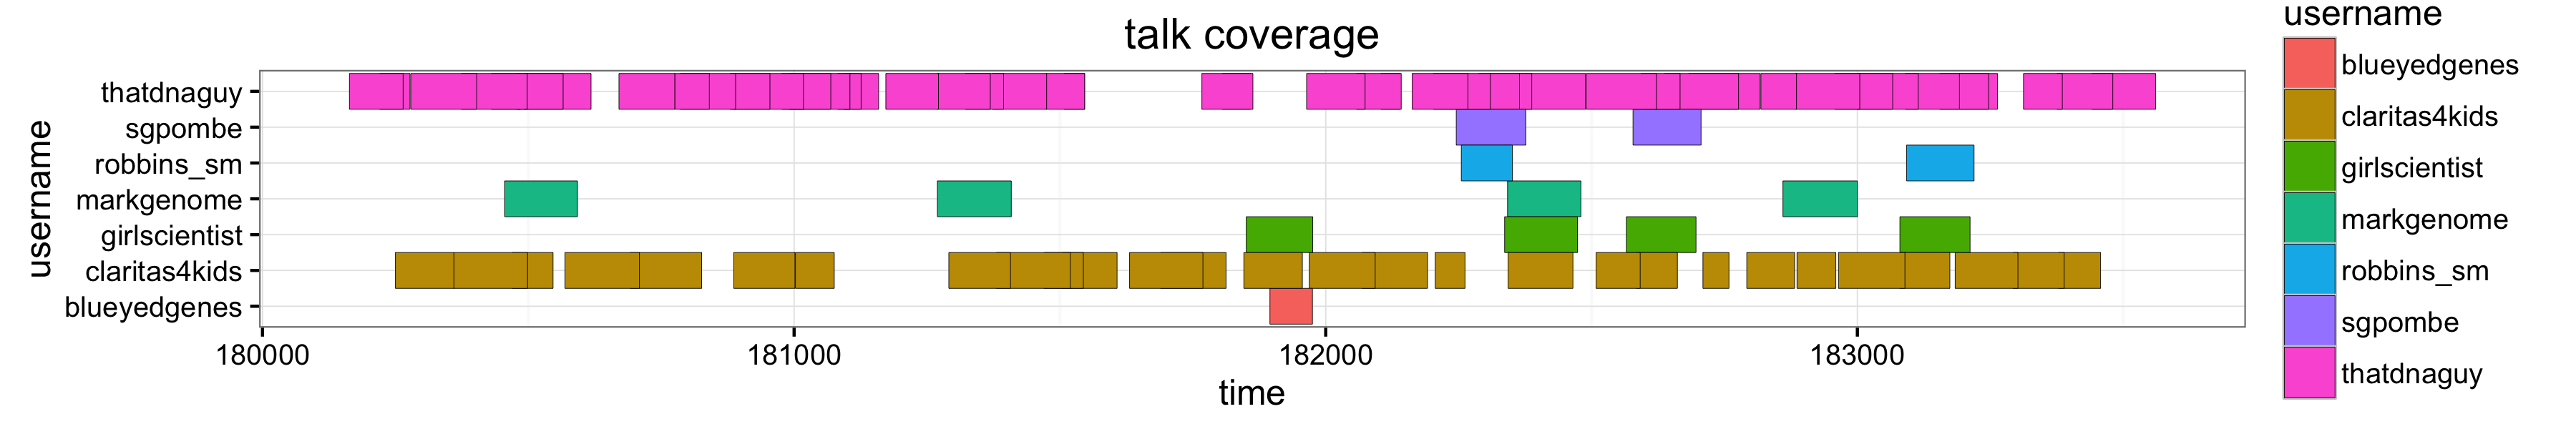

In [4]:
from IPython.display import Image, display

display(Image(filename='htt_example_km.png', width=960, height=180))

Xin Jin's talk

In [5]:
# Xin Jin
xj = df1[df1['Text'].str.contains('XJ|Xin Jin|Jin')]
xj = xj[xj['Posted at'].str.contains('2016-10-22')]
xj['date'], xj['time'], xj['nano'] = zip(*xj["Posted at"].str.split(' ').tolist())
xj['time'] = xj['time'].str.replace(':','')
xj['time'] = xj['time'].astype(int)
xj = xj.ix[(xj['time']>0) & (xj['time']<10000)]
xj.reset_index(drop=True, inplace=True)
xj.to_csv('htt_example_xj.txt', sep='\t', index=False)
xj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 7 columns):
ID             83 non-null int64
Posted at      83 non-null object
Screen name    83 non-null object
Text           83 non-null object
date           83 non-null object
time           83 non-null int64
nano           83 non-null object
dtypes: int64(2), object(5)
memory usage: 4.6+ KB


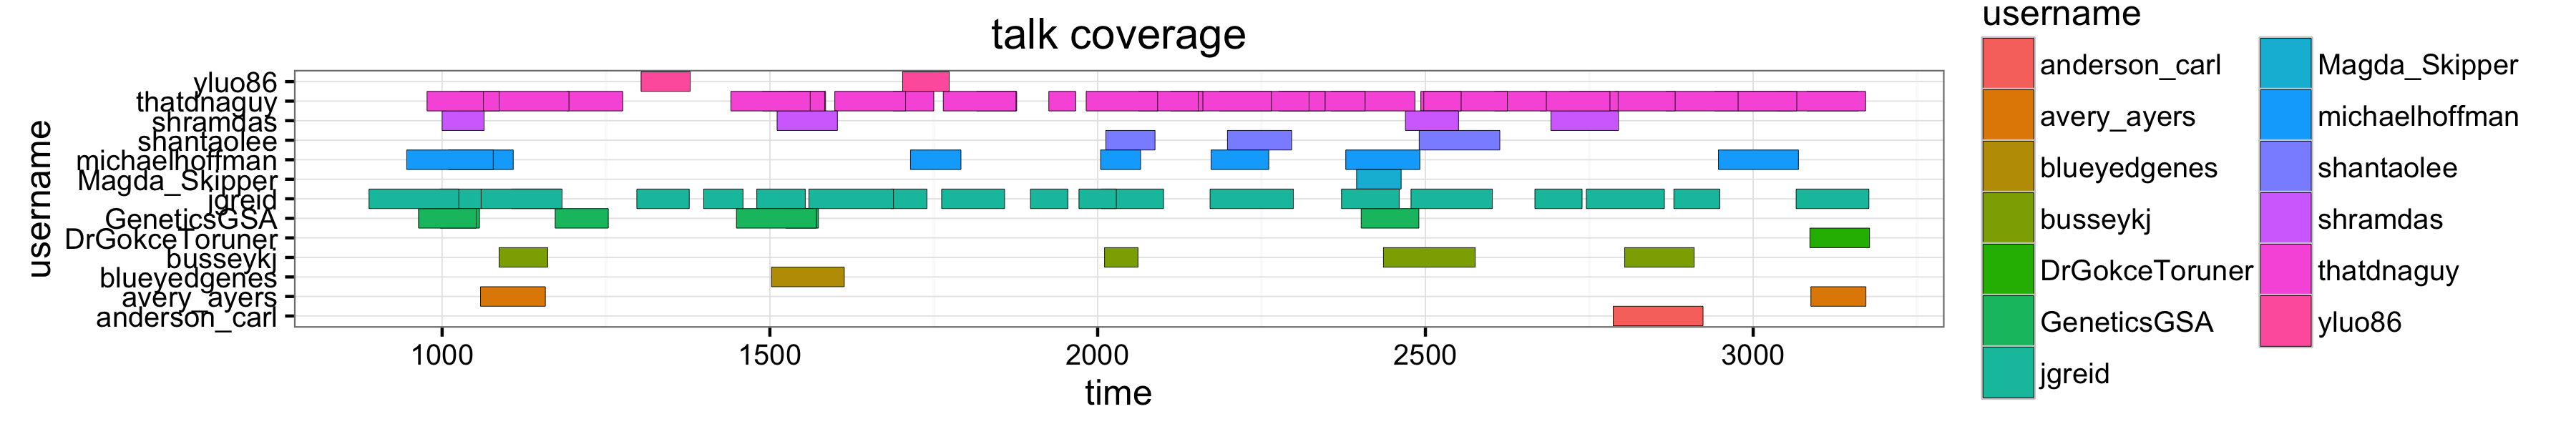

In [6]:
display(Image(filename='htt_example_xj.png', width=960, height=160))

Casey's talk

In [7]:
cb = df1[df1['Text'].str.contains('CB|Brown')]
cb = cb[cb['Posted at'].str.contains('2016-10-21')]
cb['date'], cb['time'], cb['nano'] = zip(*cb["Posted at"].str.split(' ').tolist())
cb['time'] = cb['time'].str.replace(':','')
cb['time'] = cb['time'].astype(int)
cb = cb.ix[(cb['time']>170000) & (cb['time']<190000)]
cb.reset_index(drop=True, inplace=True)
cb.reset_index(inplace=True)
cb.to_csv('htt_example_cb.txt', sep='\t', index=False)
cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 8 columns):
index          40 non-null int64
ID             40 non-null int64
Posted at      40 non-null object
Screen name    40 non-null object
Text           40 non-null object
date           40 non-null object
time           40 non-null int64
nano           40 non-null object
dtypes: int64(3), object(5)
memory usage: 2.6+ KB


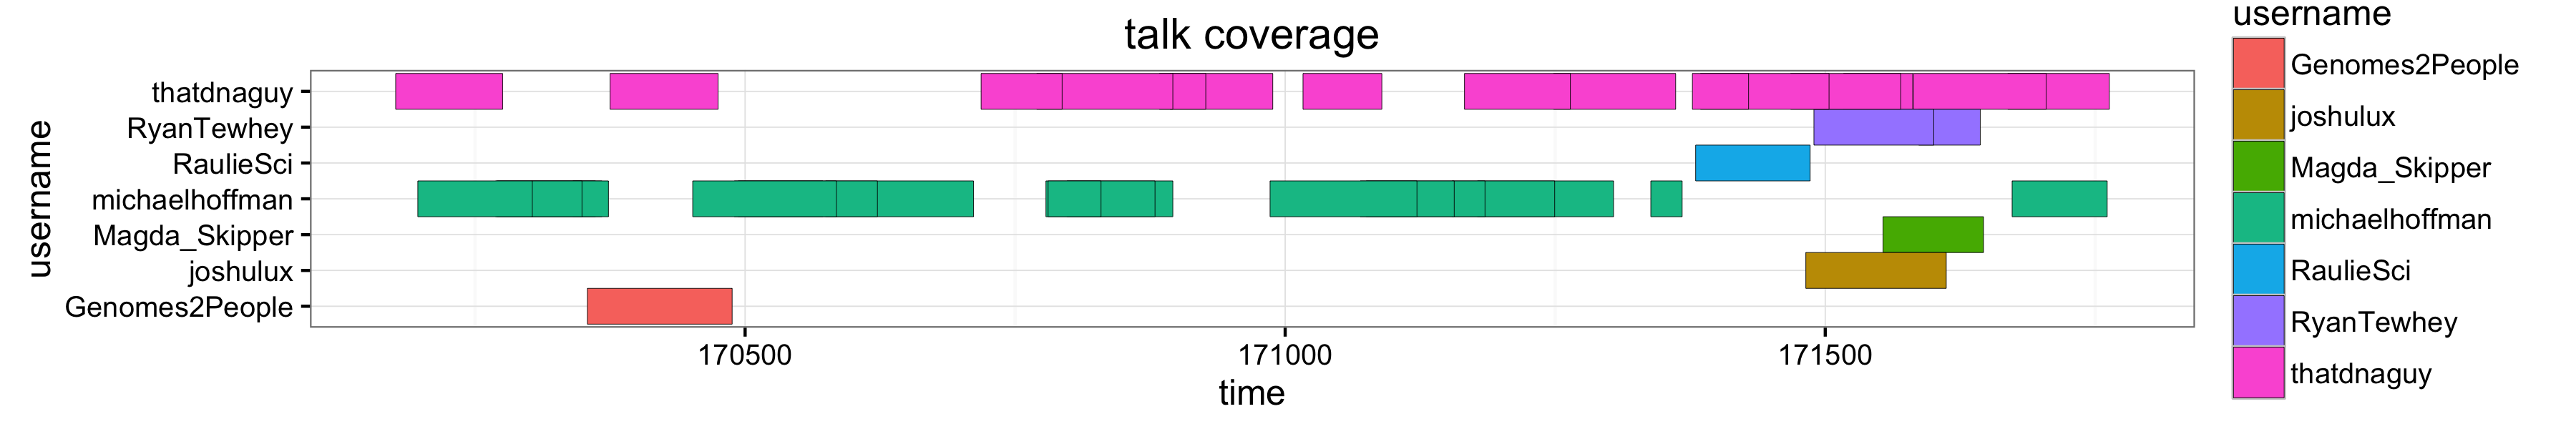

In [8]:
display(Image(filename='htt_example_cb.png', width=960, height=160))

### summary

- I find that the current method successfully demonstrates the application of high throughput tweet-sequencing coverage data extraction  
- however, the current method is too simplistic to decipher the true impact of the talk  
- for the small samples I've tested, talk coverage by HTT is approximately 2x, which turns out to be higher than NGS average read depths/coverage of some exceptional projects (yes, this contrast, however, is meaningless)  
    
- spurious associations with RT's may be as high as 38%  
- false positive rates are higher with common initials of speaker's names with this method, especially when coinciding with another speaker with the same initials (~1% for KM versus ~10% for CB)  
- although not tested due to data pulling limitations, I imagine more stringent QC measures are merited for speaker names such as Tuuli's and Alexis' (TL - it will also be present in all tweets regarding eQ'TL's, for example; AB - same with GI'AB')  
- some false positives are successfully controlled by cross-matching tweet times to scheduled talk times  
- may require further investigation by normalization across different samples and usernames  
- time could be better treated but the current method seems to be ok considering the max read length of 140    
- language and context-based analysis such as positive versus negative impact would be interesting  
